### This notebook model on the scaled on raw CPM through some transformation.

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import load_pickle, save_pickle
from datetime import datetime, timedelta
import cleaning, utils
from scipy import stats
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import make_scorer, f1_score, matthews_corrcoef, balanced_accuracy_score, accuracy_score

In [3]:
target = 'Y:/Internship/SoMin/raw/20220523/adlibrary_ads.pkl'
if os.path.getsize(target) > 0: 
    all_ads = load_pickle(target)
    print(len(all_ads))
else:
    print('empty')

38985


In [6]:
df = pd.read_csv('Y:/Internship/SoMin/Notebook/data/df_scaled.csv')
df

,Unnamed: 0,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,facebook,instagram,messenger,audience_network,demographic_dist,CPM_half,spend_log,impressions_log,CPM6,CPM6_bin
0,0,US,5435784683,Greenpeace USA,548139713319342,2022-04-29,4,2022-04-30,2022-05-02,2,...,1,1,0,0,"[{'percentage': '0.002079', 'age': '65+', 'gen...",1.444752e-10,3.89182,7.312553,532.210848,1
1,1,US,5435784683,Greenpeace USA,1069500380301716,2022-04-29,4,2022-05-03,2022-05-04,1,...,1,1,0,0,NaN,2.753850e-30,3.89182,6.212606,626.439249,2
2,2,US,5435784683,Greenpeace USA,1095252224366887,2022-04-29,4,2022-04-30,2022-05-05,5,...,1,1,0,0,"[{'percentage': '0.002037', 'age': '25-34', 'g...",2.753850e-30,3.89182,6.212606,626.439249,2
3,3,US,5435784683,Greenpeace USA,666915297749801,2022-04-29,4,2022-05-03,2022-05-05,2,...,1,1,0,0,NaN,2.753850e-30,3.89182,6.212606,626.439249,2
4,4,US,5435784683,Greenpeace USA,1008643350044019,2022-04-29,4,2022-04-30,2022-05-03,3,...,1,1,0,0,"[{'percentage': '0.001679', 'age': '45-54', 'g...",1.435714e-01,3.89182,9.769899,398.348058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140990,158707,US,69326160582,Lincoln Club of Orange County,419701022080955,2019-10-27,10,2019-10-28,2019-10-30,2,...,1,1,0,0,"[{'percentage': '0.001054', 'age': '25-34', 'g...",2.753850e-30,3.89182,7.312553,412.557369,0
140991,158708,US,69512296468,Pennsylvania Family Council,981335575768080,2021-08-12,8,2021-08-12,2021-08-21,9,...,1,0,0,0,"[{'percentage': '0.00051', 'age': '25-34', 'ge...",2.753850e-30,3.89182,9.047704,412.557369,0
140992,158709,US,69512296468,Pennsylvania Family Council,268451775062190,2021-06-23,6,2021-06-23,2021-06-28,5,...,1,1,0,0,"[{'percentage': '0.000118', 'age': '25-34', 'g...",1.444752e-10,3.89182,9.769899,412.557369,0
140993,158710,US,69512296468,Pennsylvania Family Council,268543104981416,2021-04-12,4,2021-04-12,2021-04-19,7,...,1,1,0,0,"[{'percentage': '0.000199', 'age': '13-17', 'g...",2.753850e-30,3.89182,8.922525,424.920300,0


(array([28197.,     0.,     0.,     0.,     0., 29761.,     0.,     0.,
            0., 83037.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

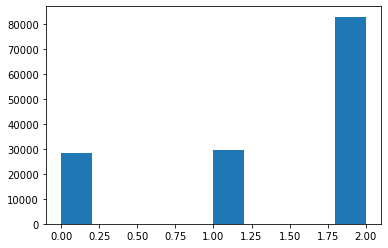

In [9]:
plt.hist(df['CPM6_bin'])

In [10]:
df.CPM6_bin.value_counts()

2    83037
1    29761
0    28197
Name: CPM6_bin, dtype: int64

In [7]:
df

,Unnamed: 0,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,facebook,instagram,messenger,audience_network,demographic_dist,CPM_half,spend_log,impressions_log,CPM6,CPM6_bin
0,0,US,5435784683,Greenpeace USA,548139713319342,2022-04-29,4,2022-04-30,2022-05-02,2,...,1,1,0,0,"[{'percentage': '0.002079', 'age': '65+', 'gen...",1.444752e-10,3.89182,7.312553,532.210848,1
1,1,US,5435784683,Greenpeace USA,1069500380301716,2022-04-29,4,2022-05-03,2022-05-04,1,...,1,1,0,0,NaN,2.753850e-30,3.89182,6.212606,626.439249,2
2,2,US,5435784683,Greenpeace USA,1095252224366887,2022-04-29,4,2022-04-30,2022-05-05,5,...,1,1,0,0,"[{'percentage': '0.002037', 'age': '25-34', 'g...",2.753850e-30,3.89182,6.212606,626.439249,2
3,3,US,5435784683,Greenpeace USA,666915297749801,2022-04-29,4,2022-05-03,2022-05-05,2,...,1,1,0,0,NaN,2.753850e-30,3.89182,6.212606,626.439249,2
4,4,US,5435784683,Greenpeace USA,1008643350044019,2022-04-29,4,2022-04-30,2022-05-03,3,...,1,1,0,0,"[{'percentage': '0.001679', 'age': '45-54', 'g...",1.435714e-01,3.89182,9.769899,398.348058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140990,158707,US,69326160582,Lincoln Club of Orange County,419701022080955,2019-10-27,10,2019-10-28,2019-10-30,2,...,1,1,0,0,"[{'percentage': '0.001054', 'age': '25-34', 'g...",2.753850e-30,3.89182,7.312553,412.557369,0
140991,158708,US,69512296468,Pennsylvania Family Council,981335575768080,2021-08-12,8,2021-08-12,2021-08-21,9,...,1,0,0,0,"[{'percentage': '0.00051', 'age': '25-34', 'ge...",2.753850e-30,3.89182,9.047704,412.557369,0
140992,158709,US,69512296468,Pennsylvania Family Council,268451775062190,2021-06-23,6,2021-06-23,2021-06-28,5,...,1,1,0,0,"[{'percentage': '0.000118', 'age': '25-34', 'g...",1.444752e-10,3.89182,9.769899,412.557369,0
140993,158710,US,69512296468,Pennsylvania Family Council,268543104981416,2021-04-12,4,2021-04-12,2021-04-19,7,...,1,1,0,0,"[{'percentage': '0.000199', 'age': '13-17', 'g...",2.753850e-30,3.89182,8.922525,424.920300,0


In [1]:
predictor=['ad_creation_month', 'delivery_period']

target=['CPM6_bin']

X = df[predictor]
y = df[target]

# y = LabelBinarizer().fit_transform(y)

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, verbose=5, objective='multi:softprof', eval_metric=['auc'])

xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
y_test_pred_proba = xgb.predict_proba(X_test)

from sklearn.metrics import mean_squared_error, accuracy_score

print()
print("REPORT")
print("Train accuracy", accuracy_score(y_train, y_train_pred))
print("Test accuracy", accuracy_score(y_test, y_test_pred))
print("Test auc score", roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr'))
print("Classification Report:", classification_report(y_test, y_test_pred))


NameError: name 'df' is not defined

In [21]:
y_test

,CPM6_bin
62928,2
131016,1
26316,2
34244,2
7740,1
...,...
3676,2
18779,2
115852,2
140023,2


In [22]:
y_test_pred_proba

array([[0.20895842, 0.21258833, 0.57845324],
       [0.19756977, 0.1968583 , 0.605572  ],
       [0.1945561 , 0.22066198, 0.58478194],
       ...,
       [0.16054723, 0.16538683, 0.67406595],
       [0.19430132, 0.21620701, 0.58949167],
       [0.19063875, 0.2264341 , 0.5829271 ]], dtype=float32)

In [25]:
matthews_corrcoef(y_test, y_test_pred)

0.047652718802523086